### Case Study: AI-Powered Strategy

## Oanda API 

In [73]:
import tpqoa
import numpy as np
import pandas as pd

In [74]:
from pylab import plt
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = 'svg'

In [75]:
import warnings
warnings.simplefilter('ignore')

In [76]:
oanda = tpqoa.tpqoa('oanda.cfg')

## The Data 

In [77]:
%%time
data = oanda.get_history(
    instrument='EUR_USD',
    start='2023-06-14',
    end='2023-06-15',
    granularity='S5',
    price='M'
)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14018 entries, 2023-06-14 00:00:00 to 2023-06-15 00:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         14018 non-null  float64
 1   h         14018 non-null  float64
 2   l         14018 non-null  float64
 3   c         14018 non-null  float64
 4   volume    14018 non-null  int64  
 5   complete  14018 non-null  bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 670.8 KB
CPU times: total: 359 ms
Wall time: 4.97 s


In [78]:
data['r'] = np.log(data['c'] / data['c'].shift(1))

In [79]:
data['d'] = np.sign(data['r'])

## The Strategy 

In [80]:
lags = 3

In [81]:
cols = list()
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['r'].shift(lag)
    cols.append(col)

In [82]:
data.head()

,o,h,l,c,volume,complete,r,d,lag_1,lag_2,lag_3
time,,,,,,,,,,,
2023-06-14 00:00:00,1.07898,1.07900,1.07897,1.07898,9,True,NaN,NaN,NaN,NaN,NaN
2023-06-14 00:00:05,1.07896,1.07898,1.07896,1.07898,4,True,0.000000,0.0,NaN,NaN,NaN
2023-06-14 00:00:10,1.07898,1.07900,1.07898,1.07900,3,True,0.000019,1.0,0.000000,NaN,NaN
2023-06-14 00:00:20,1.07901,1.07901,1.07900,1.07901,3,True,0.000009,1.0,0.000019,0.000000,NaN
2023-06-14 00:00:25,1.07900,1.07900,1.07900,1.07900,1,True,-0.000009,-1.0,0.000009,0.000019,0.0


In [83]:
data.dropna(inplace=True)

In [84]:
data['d'] = data['d'].astype(int)

## Train-Test Split

In [85]:
split = int(len(data) * 0.8)
split

11211

In [86]:
train = data.iloc[:split].copy()

In [87]:
mu, std = train.mean(), train.std()

In [88]:
train_ = (train - mu) / std

In [89]:
test = data.iloc[split:].copy()

In [90]:
test_ = (test - mu) / std

## Training of the Model

In [91]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [92]:
model = MLPClassifier(hidden_layer_sizes=[24],
                      shuffle=False,
                      max_iter=500)

In [93]:
model.fit(train_[cols], train['d'])

MLPClassifier(hidden_layer_sizes=[24], max_iter=500, shuffle=False)

In [94]:
accuracy_score(train['d'], model.predict(train_[cols]))

0.3937204531263937

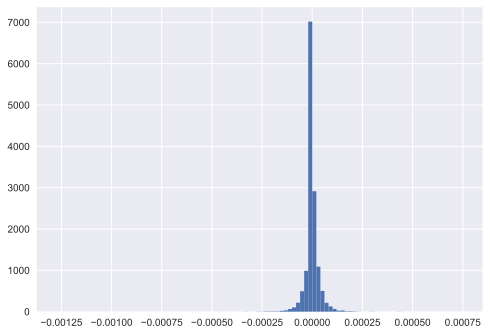

In [95]:
data['r'].hist(bins=100);

## Testing of the Model

In [96]:
test['p'] = model.predict(test_[cols])

In [97]:
accuracy_score(test['d'], test['p'])

0.41205850874063504

In [98]:
test['s'] = test['p'] * test['r']

In [99]:
test[['r', 's']].sum().apply(np.exp)

r    1.002339
s    1.001710
dtype: float64

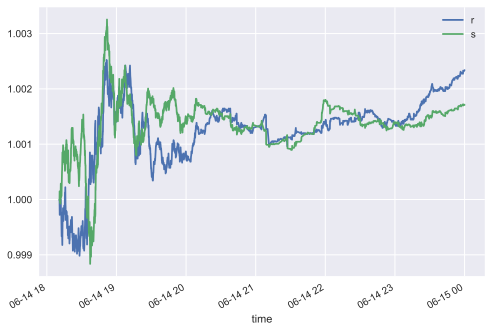

In [100]:
test[['r', 's']].cumsum().apply(np.exp).plot();

## Trading Code

In [101]:
oanda.on_success??

Signature: oanda.on_success(time, bid, ask)
Source:   
    def on_success(self, time, bid, ask):
        ''' Method called when new data is retrieved. '''
        print(time, bid, ask)
File:      d:\2024\april\major project\env\lib\site-packages\tpqoa\tpqoa.py
Type:      method

In [102]:
oanda.stream_data('EUR_USD', stop=10)  # streaming data

2024-05-15T11:06:47.141117175Z 1.08238 1.08253
2024-05-15T11:06:49.718941384Z 1.08237 1.08251
2024-05-15T11:06:50.755651581Z 1.08238 1.08253
2024-05-15T11:06:55.555688765Z 1.08239 1.08253
2024-05-15T11:07:00.925140603Z 1.08239 1.08254
2024-05-15T11:07:03.572037780Z 1.08239 1.08253
2024-05-15T11:07:12.904101292Z 1.08239 1.08254
2024-05-15T11:07:13.576205572Z 1.08239 1.08253
2024-05-15T11:07:15.579533760Z 1.08237 1.08251
2024-05-15T11:07:22.058777797Z 1.08239 1.08253


In [103]:
oanda.create_order('EUR_USD', units=50)  # opening long position



 {'id': '67', 'time': '2024-05-15T11:07:22.719746607Z', 'userID': 29105169, 'accountID': '101-001-29105169-001', 'batchID': '66', 'requestID': '97268458732316588', 'type': 'ORDER_FILL', 'orderID': '66', 'instrument': 'EUR_USD', 'units': '50.0', 'gainQuoteHomeConversionFactor': '1.0', 'lossQuoteHomeConversionFactor': '1.0', 'price': 1.08253, 'fullVWAP': 1.08253, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.08239, 'liquidity': '10000000'}], 'asks': [{'price': 1.08253, 'liquidity': '10000000'}], 'closeoutBid': 1.08239, 'closeoutAsk': 1.08253}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99974.38', 'tradeOpened': {'tradeID': '67', 'units': '50.0', 'price': 1.08253, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.0035', 'initialMarginRequired': '1.0825'}, 'halfSpreadCost': '0.0035'} 



In [104]:
oanda.create_order('EUR_USD', units=-50)  # closing long position



 {'id': '69', 'time': '2024-05-15T11:07:23.100968967Z', 'userID': 29105169, 'accountID': '101-001-29105169-001', 'batchID': '68', 'requestID': '61239661717463373', 'type': 'ORDER_FILL', 'orderID': '68', 'instrument': 'EUR_USD', 'units': '-50.0', 'gainQuoteHomeConversionFactor': '1.0', 'lossQuoteHomeConversionFactor': '1.0', 'price': 1.08239, 'fullVWAP': 1.08239, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.08239, 'liquidity': '10000000'}], 'asks': [{'price': 1.08253, 'liquidity': '9999950'}], 'closeoutBid': 1.08239, 'closeoutAsk': 1.08253}, 'reason': 'MARKET_ORDER', 'pl': '-0.007', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99974.373', 'tradesClosed': [{'tradeID': '67', 'units': '-50.0', 'price': 1.08239, 'realizedPL': '-0.007', 'financing': '0.0', 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.0035'}], 'halfSpreadCost': '0.0035'} 



## Simple Deployment

In [105]:
model.predict(test[cols])[-1]

0

In [106]:
class MLPTrader(tpqoa.tpqoa):
    def __init__(self, config_file, model, lags):
        super().__init__(config_file)
        self.model = model
        self.min_length = lags
        self.position = 0
        self.units = 100
        self.tick_data = pd.DataFrame()
    def on_success(self, time, bid, ask):
        trade = False
        print(self.ticks, end=' ')
        df = pd.DataFrame({'b': bid, 'a': ask, 'm': (ask + bid) / 2},
                         index=[pd.Timestamp(time).tz_localize(tz=None)])
        self.tick_data = pd.concat((self.tick_data, df))
        # resampling the tick data to 5 second intervals
        self.data = self.tick_data.resample('5s', label='right').last().ffill()
        self.data['r'] = np.log(self.data['m'] / self.data['m'].shift(1))
        self.data.dropna(inplace=True)
        if len(self.data) > self.min_length:
            self.min_length += 1
            # checking for long signal
            prediction = self.model.predict(
                self.data['m'].iloc[-lags-1:-1].values.reshape(1, -1))
            print(prediction)
            if prediction == 1 and self.position in [0, -1]:
                o = oanda.create_order(self.stream_instrument,
                                   units=(1 - self.position) * self.units,
                                   suppress=True, ret=True)
                print('\n*** GOING LONG ***')
                self.print_transactions(tid=int(o['id']) - 1)
                self.position = 1
            # checking for short signal
            elif prediction == -1 and self.position in [0, 1]:
                o = oanda.create_order(self.stream_instrument,
                                   units=-(1 + self.position) * self.units,
                                   suppress=True, ret=True)
                print('\n*** GOING SHORT ***')
                self.print_transactions(tid=int(o['id']) - 1)
                self.position = -1    

In [107]:
mt = MLPTrader('oanda.cfg', model, lags=lags)
mt.stream_data('EUR_USD', stop=50)

1 2 3 4 5 6 7 [-1]

*** GOING SHORT ***
  71 | 2024-05-15T11:07:43.34 | EUR_USD |   -100.0 |      0.0
8 9 10 [-1]
11 12 13 14 15 16 17 [-1]
18 19 20 21 22 23 [-1]
24 [-1]
25 26 [-1]
27 [-1]
28 29 [-1]
30 [-1]
31 32 [-1]
33 34 35 36 37 [-1]
38 [-1]
39 [-1]
40 [-1]
41 [-1]
42 43 44 [-1]
45 46 47 48 49 [-1]
50 

In [108]:
from pprint import pprint
o = mt.create_order('EUR_USD', units=-mt.position * mt.units,
                    suppress=True, ret=True)
print('\n*** POSITION CLOSED ***')
mt.print_transactions(tid=int(o['id']) - 1)
print('\n')
pprint(o)


*** POSITION CLOSED ***
  73 | 2024-05-15T11:09:03.86 | EUR_USD |    100.0 |   -0.025


{'accountBalance': '99974.348',
 'accountID': '101-001-29105169-001',
 'batchID': '72',
 'commission': '0.0',
 'financing': '0.0',
 'fullPrice': {'asks': [{'liquidity': '10000000', 'price': 1.08261}],
               'bids': [{'liquidity': '10000000', 'price': 1.08246}],
               'closeoutAsk': 1.08261,
               'closeoutBid': 1.08246,
               'type': 'PRICE'},
 'fullVWAP': 1.08261,
 'gainQuoteHomeConversionFactor': '1.0',
 'guaranteedExecutionFee': '0.0',
 'halfSpreadCost': '0.0075',
 'id': '73',
 'instrument': 'EUR_USD',
 'lossQuoteHomeConversionFactor': '1.0',
 'orderID': '72',
 'pl': '-0.025',
 'price': 1.08261,
 'reason': 'MARKET_ORDER',
 'requestID': '61239662136990405',
 'time': '2024-05-15T11:09:03.867773592Z',
 'tradesClosed': [{'financing': '0.0',
                   'guaranteedExecutionFee': '0.0',
                   'halfSpreadCost': '0.0075',
                   'price'